In [ ]:
import os
from PIL import Image
from tqdm.notebook import tqdm

# Scale images to square format without distorting proportions

This notebook scales all images to a square format so that the images can be fed well into the usual neural networks without distorting the proportions of the clothes.

The margins are automatically filled with content from the source image to avoid disturbing borders.

You can set the size (`TARGET_SIZE`) and compression quality (`JPEG_QUALITY`) of the resulting images.

Depending on the target size and system load the runtime is about 0.5-3 hours.

The scaled images will be saved in `/kaggle/working/images_224x224` (for a target size of 224) with the same directory structure as the original images and a zip file.

### Original
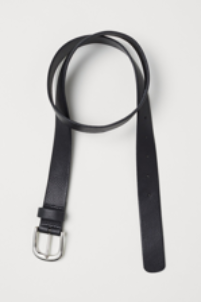

### Resized to square format
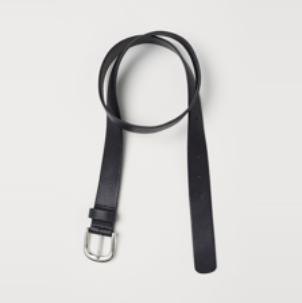

In [ ]:
def resize_to_square(source_image_path, target_size=224):
    source_image = Image.open(source_image_path, 'r')
    source_width = source_image.size[0]
    source_height = source_image.size[1]
    
    # scale image keeping the aspect ratio
    if source_width > source_height:
        scaled_width = target_size
        scaled_height = round(scaled_width*source_height/source_width)
    else:
        scaled_height = target_size
        scaled_width = round(scaled_height*source_width/source_height)
    scaled_image = source_image.resize((scaled_width, scaled_height))
    
    # place the scaled image in the center of the target square image.
    scaled_img_x = round((target_size - scaled_width)/2)
    scaled_img_y = round((target_size - scaled_height)/2)
    target_image = Image.new(mode="RGB", size=(target_size, target_size))
    target_image.paste(scaled_image, (scaled_img_x, scaled_img_y))

    # fill margins to avoid disturbing borders
    if scaled_img_x > 0:
        # fill the left and right margin (aspect ratio of source is vertical)
        left_region = scaled_image.crop((0, 0, 1, scaled_height)).resize((scaled_img_x, scaled_height))
        target_image.paste(left_region, (0, 0))
        right_region = scaled_image.crop((scaled_width-1, 0, scaled_width, scaled_height)).resize((target_size - scaled_width - scaled_img_x, scaled_height))
        target_image.paste(right_region, (scaled_width + scaled_img_x, 0))
    elif scaled_img_y > 0:
        # fill the top and bottom margin (aspect ratio of source is landscape)
        top_region = scaled_image.crop((0, 0, scaled_width, 1)).resize((scaled_width, scaled_img_y))
        target_image.paste(top_region, (0, 0))
        bottom_region = scaled_image.crop((0, scaled_height-1, scaled_width, scaled_height)).resize((scaled_width, target_size - scaled_height - scaled_img_y))
        target_image.paste(bottom_region, (0, scaled_height + scaled_img_y))
    return(target_image)

In [ ]:
resize_to_square('../input/h-and-m-personalized-fashion-recommendations/images/017/0179950001.jpg', target_size=224)

In [ ]:
TARGET_SIZE = 224 # images will be <TARGET_SIZE> pixels wide and high
JPEG_QUALITY = 50 # compression quality (100=highest quality and largest file size, 0=lowest quality and smallest file size)

ROOT_SOURCE_PATH = '../input/h-and-m-personalized-fashion-recommendations/images'
ROOT_TARGET_PATH = f'./images_{TARGET_SIZE}x{TARGET_SIZE}'

In [ ]:
total_image_count = 0
for path, _, filenames in os.walk(ROOT_SOURCE_PATH):
    for filename in filenames:
        total_image_count+=1
print(f'Found {total_image_count} images.')

In [ ]:
with tqdm(total=total_image_count) as progress_bar:
    for path, _, filenames in os.walk(ROOT_SOURCE_PATH):
        target_dir = os.path.join(ROOT_TARGET_PATH, path[len(ROOT_SOURCE_PATH)+1:])
        if not os.path.isdir(target_dir):
            os.mkdir(target_dir)
        for filename in filenames:
            source_path = os.path.join(path, filename)
            resized_image = resize_to_square(source_path, target_size=TARGET_SIZE)
            target_path = os.path.join(target_dir, filename)
            resized_image.save(target_path, "JPEG", quality=JPEG_QUALITY, optimize=True, progressive=True)
            progress_bar.update()

In [ ]:
!zip -rq all_images.zip $ROOT_TARGET_PATH